# Question 1

In [1]:
import numpy as np
import pandas as pd
from gurobipy import *
factor = pd.read_csv('FactorBetas.csv')

init = [.06, .06, .009, .05, .055, .065, .051, .005, .055, .15, .1, .07, .15, .1, .02]
bm   =  [.002, .1, 0, .3, .06, .07, .06, 0, .12, .008, .05, .05, .08, .05, .05]


In [2]:
def optimize (max_trade = 15, LogToConsole = False):
    model = Model()
    buy = model.addVars(15, vtype = GRB.CONTINUOUS, ub = 0.25, lb = 0, name = 'buy')
    sell = model.addVars(15, vtype = GRB.CONTINUOUS, ub = 0.25, lb = 0, name = 'sell')
    yb = model.addVars(15, vtype = GRB.BINARY, name = 'yb')
    ys = model.addVars(15, vtype = GRB.BINARY, name = 'ys')
    y_zero = model.addVars(15, vtype = GRB.BINARY, name = 'y_zero')

    def Variance():
        Mkt = 0
        HML = 0
        SMB = 0
        idio_vol = 0
        for i in range(15):
            weight = (init[i] + buy[i] - sell[i])
            weight_diff = weight - bm[i]
            Mkt += weight_diff * factor['Beta Market'][i]
            HML += weight_diff * factor['Beta HML'][i]
            SMB += weight_diff * factor['Beta SMB'][i]
            idio_vol += 0.1 * weight_diff *0.1 * weight_diff
        return (0.1 * Mkt * 0.1 * Mkt)  + (0.2 * HML* 0.2 * HML) + (0.2 * SMB)*(0.2 * SMB) + idio_vol 

    def sum_trade():
        s = 0
        for i in range(15):
            s = s + yb[i] + ys[i]
        return s

    def sum_weights():
        s = 0
        for i in range(15):
            weight = init[i] + buy[i] - sell[i]
            s += weight
        return s

    model.setObjective(Variance(), GRB.MINIMIZE)
    model.addConstr(sum_weights() == 1)                        
    for i in range(15):
        model.addConstr(buy[i] <= 0.25 * yb[i])
        model.addConstr(buy[i] >= 0.01 * yb[i])
        model.addConstr(sell[i] <= 0.25 * ys[i])
        model.addConstr(yb[i] + ys[i] <= 1)
        model.addConstr((2*y_zero[i]-1)*(init[i] + buy[i] - sell[i]) >= ys[i]*y_zero[i]*0.01)
        if init[i] >= 0.01:
            model.addConstr(sell[i] >= 0.01 * ys[i])
        else:
            model.addConstr(sell[i] == init[i] * ys[i])
    
    model.addConstr(sum_trade() <= max_trade)
    model.Params.LogToConsole = LogToConsole     
    model.optimize()
    model.printAttr("X")
    return model.ObjVal

In [3]:
var = []
for i in range(0,16):
    var.append(optimize(i))

Using license file C:\gurobi903\key\gurobi.lic
Academic license - for non-commercial use only


Fontier


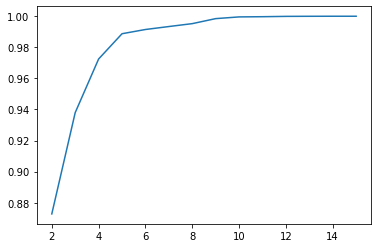

In [4]:
print("Fontier")
reduction = 1 - np.asarray(var)/var[0]
pd.Series(reduction)[2:].plot()

In [5]:
print(reduction)

[0.         0.         0.87281945 0.93795751 0.97243138 0.98868018
 0.99139915 0.99330319 0.99516927 0.99838919 0.99949548 0.99962708
 0.99983422 0.99989574 0.99992171 0.99992171]


In [6]:
optimize(5,True)

Parameter LogToConsole unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 77 rows, 75 columns and 210 nonzeros
Model fingerprint: 0xd1a970a3
Model has 461 quadratic objective terms
Model has 15 quadratic constraints
Variable types: 30 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  QMatrix range    [1e-02, 2e+00]
  QLMatrix range   [1e-02, 1e+00]
  Objective range  [4e-04, 7e-02]
  QObjective range [1e-03, 1e+00]
  Bounds range     [3e-01, 1e+00]
  RHS range        [1e+00, 5e+00]
  QRHS range       [5e-03, 1e-01]
Found heuristic solution: objective 0.0081566
Presolve removed 4 rows and 2 columns
Presolve time: 0.00s
Presolved: 146 rows, 116 columns, 434 nonzeros
Presolved model has 461 quadratic objective terms
Variable types: 56 continuous, 60 integer (60 binary)

Root relaxation: objective 1.088725e-07, 296 iterations, 0.00 seconds

    Nodes    |    Current Node

9.233155504707359e-05

At least 5 trades are needed to reduce the variance by 97.5%
The corresponding trades are:

notice that the index starts from 0 to 14 instead of 1 to 15

      buy[3]     0.242115 
      buy[8]     0.065684 
     sell[0]    0.0612085 
     sell[9]         0.15 
    sell[12]    0.0965905 

# Question 2

![Page_1](ps7_pics/2.jpg)
![Page_2](ps7_pics/1.jpg)

# Question 2 - Codes

In [7]:
import math
import scipy.stats as stat
import numpy as np
from scipy.optimize import fsolve

def BSM_put(S,sigma,r,K,T): 
    x1 = (math.log(S/K) + T * r) / (sigma * math.sqrt(T)) + 0.5 * sigma * math.sqrt(T)
    x2 = (math.log(S/K) + T * r) / (sigma * math.sqrt(T)) - 0.5 * sigma * math.sqrt(T)
    delta = stat.norm.cdf(x1)
    B = - K * math.exp(-r * T) * stat.norm.cdf(x2)
    C = S * delta + B
    P = C + K * math.exp(-r * T) - S

    return P

def _solver(lmbd):
    mu = 0.1
    r = 0.04
    T = 2
    sigma = 0.2
    eta = (mu - r) /sigma

    put = BSM_put(S = 1, sigma = eta, r = r, T = 2, K = 0.9 * lmbd)
    return 1/lmbd + put/lmbd - 1

ans = fsolve(_solver,1)[0]
print(ans)



1.1371877964962607


In [8]:
S = 1
K = 0.9 * ans
mu = 0.1
r = 0.04
T = 2
sigma = 0.2
eta = (mu - r) /sigma


x1 = (math.log(S/K) + T * r) / (sigma * math.sqrt(T)) + 0.5 * eta * math.sqrt(T)
stat.norm.cdf(-x1)

0.3398187119335354

In [9]:
1/ans * 1.5 + 1/ans * 1.5 * stat.norm.cdf(-x1)

1.7672789613926458